# Мобильное приложение по продаже продуктов

Необходимо проанализировать, как ведут себя пользователи мобильного приложения по продаже продуктов питания. В нашем распоряжении логи с действиями (событиями) пользователей, а также результаты А/A/B-эксперимента.

**Описание данных:**

* EventName — название события
* DeviceIDHash — уникальный идентификатор пользователя
* EventTimestamp — время события
* ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная


# 1. Обзор данных 

In [1]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from plotly import graph_objects as go
from scipy import stats as st
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.options.mode.chained_assignment = None
sns.set_style("white")

In [2]:
logs = pd.read_csv('8_logs_exp.csv', sep='\t')

In [3]:
display(logs.sample(5))
display(logs.info())
print('Дубликатов:', logs.duplicated().sum())
display(logs['EventName'].unique())

,EventName,DeviceIDHash,EventTimestamp,ExpId
101556,PaymentScreenSuccessful,4125817697369814441,1564852194,248
108988,MainScreenAppear,9182444363400946277,1564890752,247
207482,MainScreenAppear,7098982511069377087,1565114798,247
119308,MainScreenAppear,2991661439852366258,1564915274,248
120476,MainScreenAppear,5286459037591191376,1564917046,246


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

Дубликатов: 413


array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

* В нашем распоряжении 244126 логов
* Пропущенных значений нет
* Всего в логах фигурируют 5 событий
* Дубликатов: 413

**Необходимо:**

* Изменить названия столбцов
* Добавить поле с датой и временем и отдельное поле с датой
* Разобраться с дубликатами

# 2. Предобработка данных

In [4]:
logs = logs.rename(columns={"EventName": "event", "DeviceIDHash": "user_id", 
                            "EventTimestamp": "timestamp", "ExpId": "test_group"})
logs.sample()

,event,user_id,timestamp,test_group
156348,OffersScreenAppear,1056436874470887468,1565007007,247


In [5]:
print('Дубликатов', logs.duplicated().sum())
#display(logs[logs.duplicated()].sort_values(['user_id', 'timestamp']))

print('Примеры дублей:')
display(logs[(logs['user_id']==77364241990273403) & 
              (logs['event'].values == 'PaymentScreenSuccessful') & (logs['timestamp'] == 1565044732)]) # index 176812 и 176813

display(logs[(logs['user_id']==33176906322804559) & 
             (logs['event'].values == 'MainScreenAppear') & (logs['timestamp'] == 1564933075)]) # index 130557 и 130558

Дубликатов 413
Примеры дублей:


,event,user_id,timestamp,test_group
176812,PaymentScreenSuccessful,77364241990273403,1565044732,246
176813,PaymentScreenSuccessful,77364241990273403,1565044732,246


,event,user_id,timestamp,test_group
130557,MainScreenAppear,33176906322804559,1564933075,248
130558,MainScreenAppear,33176906322804559,1564933075,248


In [6]:
# Создадим поле `datetime` с датой и временем:
logs['datetime'] = pd.to_datetime(logs['timestamp'], unit='s')

# Добавим поле с датой:
logs['date'] = pd.to_datetime(logs['datetime'].dt.date)
display(logs.sample(5))
print(logs.info())

,event,user_id,timestamp,test_group,datetime,date
109370,MainScreenAppear,170935625628929269,1564893034,246,2019-08-04 04:30:34,2019-08-04
242154,PaymentScreenSuccessful,518781617060869985,1565205621,246,2019-08-07 19:20:21,2019-08-07
221715,OffersScreenAppear,7583394010848707296,1565169866,247,2019-08-07 09:24:26,2019-08-07
72099,MainScreenAppear,2487220710747924077,1564775855,248,2019-08-02 19:57:35,2019-08-02
210892,CartScreenAppear,8103761944629157683,1565121020,246,2019-08-06 19:50:20,2019-08-06


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event       244126 non-null  object        
 1   user_id     244126 non-null  int64         
 2   timestamp   244126 non-null  int64         
 3   test_group  244126 non-null  int64         
 4   datetime    244126 non-null  datetime64[ns]
 5   date        244126 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB
None



Значения в полях с датами отображаются корректно. Типы полей теперь верны.

In [7]:
# Взглянем на дубли:
display(logs.iloc[[176812, 176813, 130557, 130558]])

,event,user_id,timestamp,test_group,datetime,date
176812,PaymentScreenSuccessful,77364241990273403,1565044732,246,2019-08-05 22:38:52,2019-08-05
176813,PaymentScreenSuccessful,77364241990273403,1565044732,246,2019-08-05 22:38:52,2019-08-05
130557,MainScreenAppear,33176906322804559,1564933075,248,2019-08-04 15:37:55,2019-08-04
130558,MainScreenAppear,33176906322804559,1564933075,248,2019-08-04 15:37:55,2019-08-04


Похоже, что это действительно задвоения. Удалим.

In [8]:
print('Логов до удаления дубликатов:', len(logs))
print('Дубликатов:', logs.duplicated().sum())
logs.drop_duplicates(inplace=True)
print('Логов после удаления дубликатов:', len(logs))

Логов до удаления дубликатов: 244126
Дубликатов: 413
Логов после удаления дубликатов: 243713


**Итог:**

* Скорректировали названия полей
* Добавили поле datetime с датой и временем
* Создали поле date с датой
* Удалили дубли

# 3. Общий анализ данных

**3.1. Количество логов и пользователей**

In [9]:
print('Всего событий:', len(logs))
print('Всего пользователей:', logs['user_id'].nunique())

Всего событий: 243713
Всего пользователей: 7551


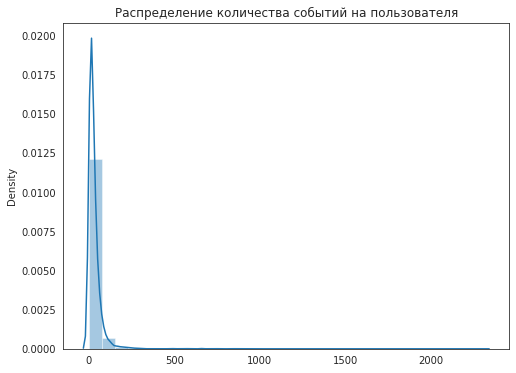

In [10]:
# Посмотрим, сколько событий в среднем приходится на пользователя:
events_by_user = logs.groupby('user_id').agg(event_count = ('event', 'count'))

plt.figure(figsize = (8,6))
plt.title('Распределение количества событий на пользователя')
sns.distplot(events_by_user['event_count'], bins=30) 
plt.xlabel('')
plt.show()

Распределение не нормально, поэтому для оценки среднего возьмём медиану.

In [11]:
print('Среднее значение событий на пользователя:', int(events_by_user['event_count'].median()))

Среднее значение событий на пользователя: 20


**3.2. Период**

In [12]:
logs['datetime'].describe()

count                  243713
unique                 176654
top       2019-08-01 14:40:35
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: datetime, dtype: object

Мы располагаем данными за период с 25.07.2019 по 07.08.2019.

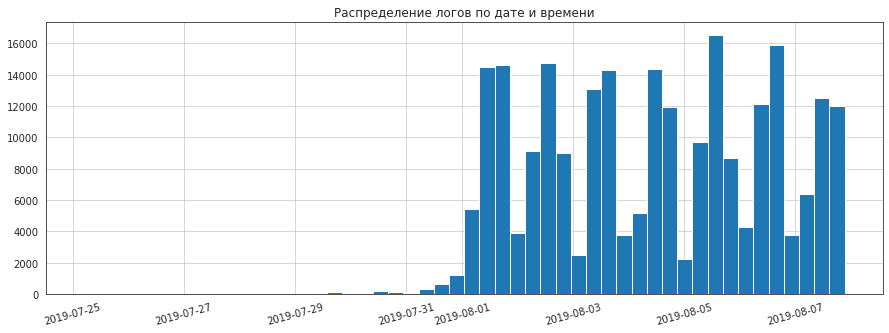

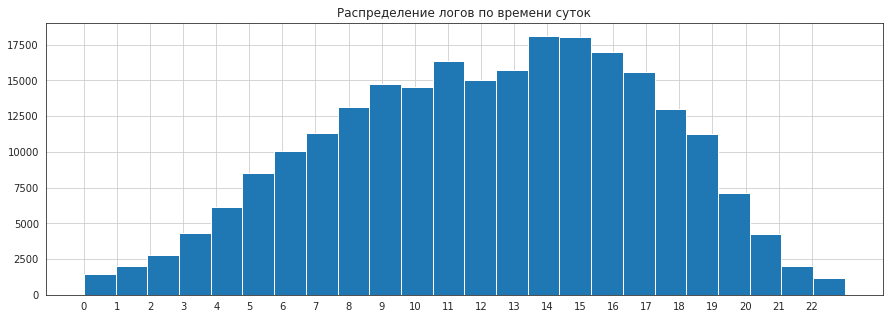

In [13]:
# Построим гистограмму по дате и времени:
plt.title('Распределение логов по дате и времени')
logs['datetime'].hist(bins=50, xrot=15,  figsize=(15, 5))
plt.show()

plt.title('Распределение логов по времени суток')
logs['datetime'].dt.hour.hist(bins=24, figsize=(15, 5))
plt.xticks(range(0, 23))
plt.show()

* Из графика видно, что данные за июль не полные
* Заметна периодичность во времени: в ночные часы событий меньше, чем днём

Для корректности анализа будем использовать данные за период с **01.08.2019 по 07.08.2019**

In [14]:
nlogs_before = len(logs)
nusers_before = logs['user_id'].nunique()
print('Всего событий:', nlogs_before)
print('Всего пользователей:', nusers_before)

logs = logs[logs['datetime'] >= '2019-08-01'].copy()
print()

# Посмотрим, сколько всего событий и пользователей осталось в логах:
print('Событий после корректировки периода:', len(logs))
print('Пользователей после корректировки периода:', logs['user_id'].nunique())
print()

# Изменения:
print('Изменение количества логов:', len(logs)-nlogs_before, '({:.1%})'.format((len(logs)-nlogs_before)/nlogs_before))
print('Изменение количества пользователей:', logs['user_id'].nunique()-nusers_before, '({:.1%})'.format((logs['user_id'].nunique()-nusers_before)/nusers_before))

Всего событий: 243713
Всего пользователей: 7551

Событий после корректировки периода: 240887
Пользователей после корректировки периода: 7534

Изменение количества логов: -2826 (-1.2%)
Изменение количества пользователей: -17 (-0.2%)


In [15]:
# Проверим, что у нас есть пользователи из всех экспериментальных групп:
logs.groupby('test_group').agg(count=('user_id','count'))

,count
test_group,
246,79302
247,77022
248,84563


Размеры групп различаются, что говорит о неоптимальности разбиения данных по группам. В будущем стоит над этим поработать.



# 4. Воронка событий 

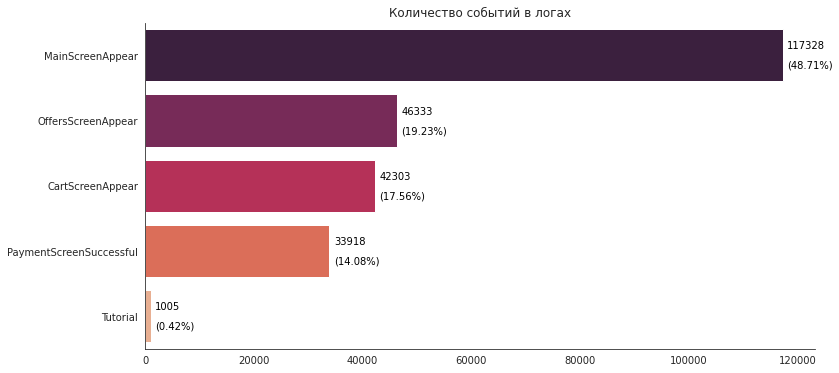

In [16]:
# Сгруппируем логи по событиям и посмотрим их количество:
events = logs.groupby('event').agg(count=('user_id', 'count')).sort_values('count', ascending=False).reset_index()

plt.figure(figsize=(12,6))
plt.title('Количество событий в логах')
sns.barplot(x=events['count'], y=events['event'], palette='rocket', orient='h')

for i, v in enumerate(events['count'].values):
    plt.text(v + 800, i - 0.1, str(v), color='black', fontsize = 10)
    plt.text(v + 800, i + 0.2, '({:.2%})'.format(v / events['count'].sum()), color='black', fontsize = 10)

plt.xlabel('')
plt.ylabel('')
sns.despine()
plt.show()

* MainScreenAppear (Главный экран) увидели 117328 раз
* OffersScreenAppear (Продающий экран) увидели 46333 раз
* CartScreenAppear (Корзина) увидели 42303 раз
* PaymentScreenSuccessful (Завершение оплаты) увидели 33918 раз
* Tutorial (Урок) просмотрели 1005 раз

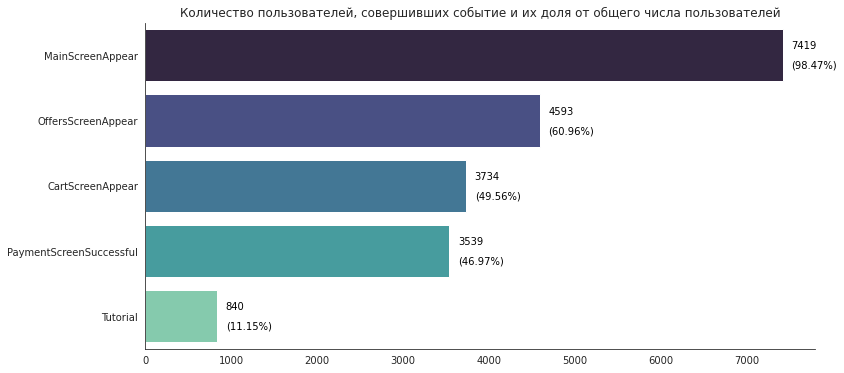

In [17]:
users_per_event = logs.groupby('event').agg(users=('user_id','nunique')).sort_values('users', ascending=False).reset_index()
users_per_event

plt.figure(figsize=(12, 6))
plt.title('Количество пользователей, совершивших событие и их доля от общего числа пользователей')
sns.barplot(y=users_per_event['event'], x=users_per_event['users'], palette='mako', orient='h')

for i, v in enumerate(users_per_event['users'].values):
    plt.text(v + 100, i - 0.1, str(v), color='black', fontsize = 10)
    plt.text(v + 100, i + 0.2, '({:.2%})'.format(v / logs['user_id'].nunique()), color='black', fontsize = 10)
    
plt.xlabel('')
plt.ylabel('')
sns.despine()
plt.show()

* Главную страницу увидели 7419 пользователей (98.5% от общего числа пользователей) - почти все
* Страницу товара просмотрели 4593 пользователей (61% от общего числа)
* Корзину просмотрели 3734 пользователя (49.6% от общего числа)
* Завершили оплату 3539 пользователей (47% от общего числа)
* Урок просмотрели 840 пользователей (11% от общего числа)

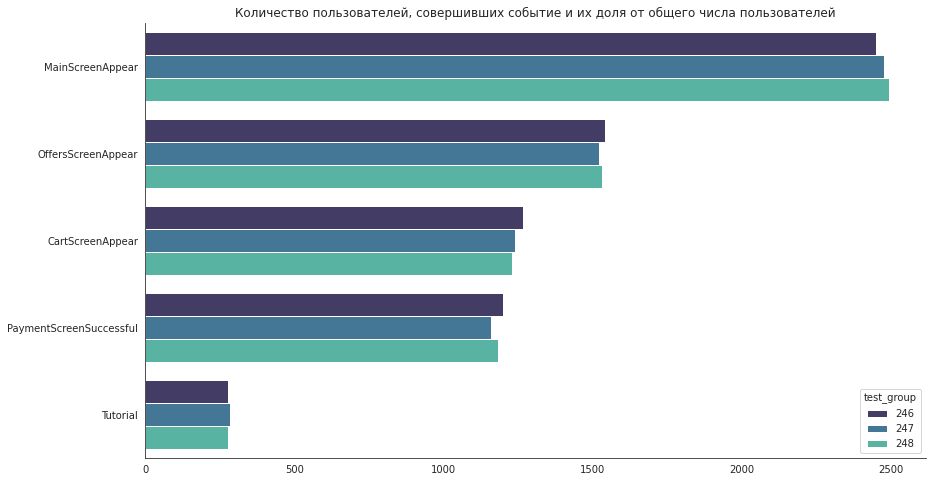

In [18]:
#Посмотрим на эти же данные, только с разбивкой по тестовым группам, чтобы оценить согласованность групп между собой.
users_per_event = logs.groupby(['event','test_group']).agg(users=('user_id','nunique')).sort_values('users', ascending=False).reset_index()
users_per_event

plt.figure(figsize=(14, 8))
plt.title('Количество пользователей, совершивших событие и их доля от общего числа пользователей')
sns.barplot(y=users_per_event['event'], x=users_per_event['users'], hue=users_per_event['test_group'], palette='mako', orient='h')

plt.xlabel('')
plt.ylabel('')
sns.despine()
plt.show()


Из перового графика видно, что не все пользователи посещали Главный экран, однако, в логах они всё равно фигурируют. Значит, просмотр Главной страницы (просмотр Урока и, возможно, и другие шаги) не является обязательным условием совершения покупки.

А на последнем графике видно, что тестовые группы составлены корректно - их представители распределены по событиям более-менее равномерно.

**Продуктовая воронка с учётом последовательности событий**

Наиболее вероятная последовательность событий, ведущая к продаже, выглядит так:

1. Просмотр главной страницы
2. Просмотр товара
3. Просмотр корзины
4. Завершение оплаты

Просмотр урока в цепочку событий не входит.

In [20]:
users = logs[logs['event'] != 'Tutorial'].pivot_table(
    index='user_id', 
    columns='event', 
    values='datetime',
    aggfunc='min')

step_1 = ~users['MainScreenAppear'].isna()
step_2 = step_1 & (users['OffersScreenAppear'] > users['MainScreenAppear'])
step_3 = step_2 & (users['CartScreenAppear'] > users['OffersScreenAppear'])
step_4 = step_3 & (users['PaymentScreenSuccessful'] > users['CartScreenAppear'])

n_main_screen = users[step_1].shape[0]
n_offers_screen = users[step_2].shape[0]
n_cart_screen = users[step_3].shape[0]
n_payment_success = users[step_4].shape[0]

# print('Посетителей:', n_main_screen)
# print('Просмотрели товар:', n_offers_screen)
# print('Просмотрели корзину:', n_cart_screen)
# print('Оплатили:', n_payment_success)

events_name = ['Посетителей', 'Просмотрели товар', 'Просмотрели корзину', 'Оплатили']
n_users = [n_main_screen, n_offers_screen, n_cart_screen, n_payment_success]

fig = go.Figure(go.Funnel(
    y = events_name,
    x = n_users
    ))
fig.show()

так, воронка выглядит следующим образом:

* 7419 пользователей просмотрели Главный экран
* из них 4201 просмотрели Товар (56.6%)
* из них 1767 перешли в Корзину (42.1% от предыдущего шага)
* из них 454 завершили Оплату (25.7% от предыдущего шага)

Больше всего пользователей теряется после первого шага - только чуть больше половины людей переходят на карточку Товара.

По каждому шагу воронки прошло всего 6% пользователей (454 из 7419, начавших с Главного экрана). При этом в целом оплатили заказ 3539 человек. Т.е. бОльшая часть покупателей (3085 или 87%) шли к оплате каким-то иным путём.

# 5. Результаты А/А/В-эксперимента

In [21]:
# Подсчитаем количество пользователей в каждой тестовой группе:
logs.groupby('test_group').agg(count=('user_id','nunique'))

,count
test_group,
246,2484
247,2513
248,2537



* Разницы в количестве почти нет

Однако, нам нужно убедиться в корректности самой разбивки на группы. Для этого для начала проверим находят ли статистические критерии разницу между выборками 246 и 247 (А/А-тест).

**Z-тест**

In [22]:
"""
Функция принимает на вход два датафрейма с логами и по заданному событию попарно проверяет 
есть ли статистически значимая разница между долями пользователей, совершивших его в группе 1 и группе 2
Входные параметры:
    df1, df2 - датафреймы с логами
    event - событие
    alpha - критический уровень статистической значимости
"""
def z_test(df1, df2, event, alpha):
    alpha = alpha

    # число пользователей в группе 1 и группе 2:
    n_users = np.array([df1['user_id'].nunique(), df2['user_id'].nunique()])

    # число пользователей, совершивших событие в группе 1 и группе 2
    success = np.array([df1[df1['event'] == event]['user_id'].nunique(), df2[df2['event'] == event]['user_id'].nunique()])

    # пропорции успехов в группах:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1] 
    # пропорция успехов в комбинированном датасете:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # разница пропорций в датасетах
    difference = p1 - p2 

    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('\n'+'\033[1m' + event + ':' + '\033[0m')
    print('p-значение: ', p_value)

    if (p_value < alpha):
        print("Отвергаем нулевую гипотезу: между долями есть значимая разница")
    else:
        print("Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными")

In [24]:
# Составим список всех возможных событий:
EVENTS_ARRAY = logs['event'].unique()
# Зададим критический уровень статистической значимости:
ALPHA = 0.1/20

In [25]:
# Проверим, есть ли статистически значимая разница между контрольными группами 246 и 247:
for event in EVENTS_ARRAY:
    z_test(logs[logs['test_group'] == 246], logs[logs['test_group'] == 247], event, ALPHA)


Tutorial:
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear:
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* При заданном уровне значимости у нас нет оснований считать группы 246 и 247 разными.
* Обратим внимание на PaymentScreenSuccessful (Завершение оплаты) - полученное p-value говорит о том, что хотя доли оплативших заказ пользователей не равны, с вероятностью в 11.5% такое или большее различие можо получить случайно. Т.е. если бы мы допустили уровень ошибки, например, 12%, то пришлось бы признать, что между долями есть существенная разница. И, соответственно, пришлось бы признать выборки не подходящими для эксперимента.

In [26]:
# Проверим есть ли статистически значимая разница между контрольной 246 и экпериментальной 248 группами:
for event in EVENTS_ARRAY:
    z_test(logs[logs['test_group'] == 246], logs[logs['test_group'] == 248], event, ALPHA)


Tutorial:
p-значение:  0.8264294010087645
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear:
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* При заданном уровне значимости различия между группами 246 и 248 не обнаружились.
* Однако, при допустимом уровне ошибки 8%, мы получили бы разницу на этапе Просмотра корзины.

In [27]:
# Проверим есть ли статистически значимая разница между контрольной 247 и экпериментальной 248 группами:
for event in EVENTS_ARRAY:
    z_test(logs[logs['test_group'] == 247], logs[logs['test_group'] == 248], event, ALPHA)


Tutorial:
p-значение:  0.765323922474501
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear:
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



* Тут мы и близко не можем считать, что между нашими группами есть существенная разница.

In [28]:
# Проверим есть ли статистически значимая разница между объединённой контрольной и экпериментальной 248 группами:
for event in EVENTS_ARRAY:
    z_test(pd.concat([logs[logs['test_group'] == 246], logs[logs['test_group'] == 247]]), logs[logs['test_group'] == 248], 
           event, ALPHA)


Tutorial:
p-значение:  0.764862472531507
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

MainScreenAppear:
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

OffersScreenAppear:
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

CartScreenAppear:
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

PaymentScreenSuccessful:
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


* И снова у нас нет оснований считать доли разными.

Фиксируем, что изменение шрифтов во всём приложении на поведение пользователей не повлияло.

# 6. Общий вывод 

В нашем распоряжении оказалось 240887 логов, 7534 пользователя и всего пять возможных событий.

**Анализ поведения пользователей**

Среднее количество событий на пользователя: 20.

1. Распределение логов по событиям выглядит следующим образом:
  * MainScreenAppear (Главный экран) увидели 117328 раз
  * OffersScreenAppear (Продающий экран) увидели 46333 раз
  * CartScreenAppear (Корзина) увидели 42303 раз
  * PaymentScreenSuccessful (Завершение оплаты) увидели 33918 раз
  * Tutorial (Урок) просмотрели 1005 раз
2. Воронка событий (без учёта последовательности):
  * Главную страницу увидели 7419 пользователей (98.5% от общего числа пользователей) - почти все
  * Страницу товара просмотрели 4593 пользователей (61% от общего числа)
  * Корзину просмотрели 3734 пользователя (49.6% от общего числа)
  * Завершили оплату 3539 пользователей (47% от общего числа)
  * Урок просмотрели 840 пользователей (11% от общего числа)

Не все пользователи посещали Главный экран, однако, в логах они всё равно фигурируют. Значит, просмотр Главной страницы (просмотр Урока и, возможно, и другие шаги) не является обязательным условием совершения покупки.

3. Воронка событий с учётом последовательности событий:
  * 7419 пользователей просмотрели Главный экран
  * из них 4201 просмотрели Товар (56.6%)
  * из них 1767 перешли в Корзину (42.1% от предыдущего шага)
  * из них 454 завершили Оплату (25.7% от предыдущего шага)

Больше всего пользователей теряется после первого шага - только чуть больше половины людей переходят на карточку Товара.

По каждому шагу воронки прошло всего 6% пользователей (454 из 7419, начавших с Главного экрана). При этом в целом оплатили заказ 3539 человек. Т.е. бОльшая часть покупателей (3085 или 87%) шли к оплате каким-то иным путём.

**Проверка результатов А/А/В-эксперимента**

Размеры тестовых групп несколько различаются:

* 246(А) : 79302 логов
* 247(А) : 77022 логов
* 248(В) : 84563 логов

В будущем стоит поработать над принципом выделения групп, чтобы их размер был одинаковым.

**Количество уникальных пользователей по группам:**

* 246(А) : 2484
* 247(А) : 2513
* 248(В) : 2537

Множесто А/В-тестов, проведённых по каждому из событий, не обнаружили статистически значимой разницы между группами. Т.е. изменение шрифтов во всём приложении на поведение пользователей не повлияло.